In [38]:
# Imports and reproducibility
from __future__ import annotations

import os
import sys
import random
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 

from skfda import representation

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [39]:
# Hyperparameters
@dataclass(frozen=True)
class FAEConfig:
    n_rep: int = 5
    n_basis_project: int = 20
    n_basis_revert: int = 20
    basis_type_project: str = "Bspline"   # "Bspline" or "Fourier"
    basis_type_revert: str = "Bspline"    # "Bspline" or "Fourier"

    penalty: Optional[str] = "diff"       # None or "diff"
    lamb: float = 1e-3

    epochs: int = 5000
    batch_size: int = 28
    lr: float = 1e-3
    weight_decay: float = 1e-6
    init_weight_sd: Optional[float] = 0.5

    split_rate: float = 0.8
    n_iter: int = 20
    base_seed: int = 123

    log_every: int = 100
    device: str = "cpu"

In [40]:
# Basis construction
def build_basis_fc(
    tpts: torch.Tensor,
    n_basis: int,
    basis_type: str
) -> torch.Tensor:
    """
    Returns basis evaluated on tpts as a torch tensor of shape [n_time, n_basis].
    """
    t_min = float(torch.min(tpts))
    t_max = float(torch.max(tpts))

    if basis_type == "Bspline":
        basis = representation.basis.BSpline(n_basis=n_basis, order=4)
    elif basis_type == "Fourier":
        basis = representation.basis.Fourier([t_min, t_max], n_basis=n_basis)
    else:
        raise ValueError(f"Unknown basis_type: {basis_type}")

    # skfda returns [n_time, n_basis, 1] for derivative=0
    eval_ = basis.evaluate(tpts, derivative=0)[:, :, 0]
    return torch.from_numpy(eval_).float()

In [41]:
# Model class (FAE) 
class FAEVanilla(nn.Module):
    def __init__(self, n_basis_project, n_rep, n_basis_revert, init_weight_sd=None, nonlinear=False):
        super().__init__()
        self.nonlinear = nonlinear

        if not nonlinear:
            self.encoder = nn.Linear(n_basis_project, n_rep, bias=False)
            self.decoder = nn.Linear(n_rep, n_basis_revert, bias=False)
            self.activation = nn.Identity()
        else:
            self.fc1 = nn.Linear(n_basis_project, 100, bias=False)
            self.fc2 = nn.Linear(100, n_rep, bias=False)
            self.fc3 = nn.Linear(n_rep, 100, bias=False)
            self.fc4 = nn.Linear(100, n_basis_revert, bias=False)
            self.activation = nn.Sigmoid()

        if init_weight_sd is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=init_weight_sd)

    @staticmethod
    def project(x, tpts, basis_fc):
        t = tpts.flatten() if tpts.ndim > 1 else tpts
        dt = t[1:] - t[:-1]
        zero = torch.zeros(1, device=x.device, dtype=x.dtype)
        W = 0.5 * torch.cat([zero, dt]) + 0.5 * torch.cat([dt, zero])

        n_time = x.shape[1]
        if basis_fc.shape[0] != n_time and basis_fc.shape[1] == n_time:
            basis_fc = basis_fc.T
        if basis_fc.shape[0] != n_time:
            raise RuntimeError(f"basis_fc shape {basis_fc.shape} not compatible with n_time={n_time}")

        return (x * W) @ basis_fc

    @staticmethod
    def revert(coef, basis_fc):
        # basis_fc can be [n_time, n_basis] or [n_basis, n_time]
        if basis_fc.shape[0] != coef.shape[1] and basis_fc.shape[1] == coef.shape[1]:
            # if basis_fc is [n_time, n_basis], we want coef @ basis_fc.T -> [batch, n_time]
            return coef @ basis_fc.T
        elif basis_fc.shape[0] == coef.shape[1]:
            # basis_fc is [n_basis, n_time] -> coef @ basis_fc
            return coef @ basis_fc
        else:
            raise RuntimeError(f"basis_fc shape {basis_fc.shape} not compatible with coef shape {coef.shape}")

    def forward(self, x, tpts, basis_fc_project, basis_fc_revert):
        feature = self.project(x, tpts, basis_fc_project)

        if not self.nonlinear:
            rep = self.activation(self.encoder(feature))
            coef = self.decoder(rep)
        else:
            t1 = self.activation(self.fc1(feature))
            rep = self.fc2(t1)
            t2 = self.activation(self.fc3(rep))
            coef = self.fc4(t2)

        x_hat = self.revert(coef, basis_fc_revert)
        return x_hat, rep, feature, coef

In [42]:
# Loss + penalty
def diff_penalty(coef: torch.Tensor) -> torch.Tensor:
    # coef: [n_subject, n_basis]
    # second difference along basis index
    delta = coef[:, 2:] - 2 * coef[:, 1:-1] + coef[:, :-2]
    return torch.mean(torch.sum(delta**2, dim=1))

In [43]:
# One-epoch train + evaluation functions
@torch.no_grad()
def evaluate_reconstruction(
    model: nn.Module,
    x: torch.Tensor,
    tpts: torch.Tensor,
    basis_fc_project: torch.Tensor,
    basis_fc_revert: torch.Tensor,
    mse_loss: nn.Module,
    device: torch.device
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    model.eval()
    x = x.to(device).float()
    x_hat, rep, feature, coef = model(x, tpts, basis_fc_project, basis_fc_revert)
    loss = mse_loss(x_hat, x)
    return x_hat, rep, loss, coef


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    tpts: torch.Tensor,
    basis_fc_project: torch.Tensor,
    basis_fc_revert: torch.Tensor,
    optimizer: optim.Optimizer,
    mse_loss: nn.Module,
    device: torch.device,
    penalty: Optional[str],
    lamb: float
) -> Dict[str, float]:
    model.train()
    total_loss = 0.0
    total_score_loss = 0.0
    n_batches = 0

    for batch in loader:
        optimizer.zero_grad()
        x = batch.to(device).float()

        x_hat, rep, feature, coef = model(x, tpts, basis_fc_project, basis_fc_revert)

        # score layer loss only if shapes match
        score_loss = torch.tensor(0.0, device=device)
        if feature.shape == coef.shape:
            score_loss = mse_loss(feature, coef)

        pen_val = torch.tensor(0.0, device=device)
        if penalty == "diff":
            pen_val = diff_penalty(coef)

        loss = mse_loss(x_hat, x) + lamb * pen_val
        loss.backward()
        optimizer.step()

        total_loss += float(loss.detach().cpu())
        total_score_loss += float(score_loss.detach().cpu())
        n_batches += 1

    return {
        "train_loss": total_loss / max(n_batches, 1),
        "score_loss": total_score_loss / max(n_batches, 1),
    }

In [44]:
# Full experiment loop
def run_fae_experiment(
    x: torch.Tensor,                  # [n_subject, n_time]
    label: np.ndarray,                # [n_subject]
    tpts: torch.Tensor,               # [n_time] or [n_time,1]
    cfg: FAEConfig,
    nonlinear: bool = False
) -> Dict[str, List]:
    device = torch.device(cfg.device)

    # basis on device once
    basis_fc_project = build_basis_fc(tpts, cfg.n_basis_project, cfg.basis_type_project).to(device)
    basis_fc_revert  = build_basis_fc(tpts, cfg.n_basis_revert,  cfg.basis_type_revert).to(device)
    tpts = tpts.to(device).float()

    mse_loss = nn.MSELoss()

    # seeds for each replicate
    set_seed(cfg.base_seed)
    replicate_seeds = random.sample(range(5000), cfg.n_iter)

    history = {
        "test_recon_loss": [],
        "train_recon_loss": [],
        "test_class_acc": [],
        "train_class_acc": [],
        "per_epoch_test_recon_loss": [[] for _ in range(cfg.epochs // cfg.log_every)],
        "per_epoch_test_class_acc": [[] for _ in range(cfg.epochs // cfg.log_every)],
    }

    X_np = x.detach().cpu().numpy()
    y_np = np.asarray(label)

    for r in range(cfg.n_iter):
        set_seed(replicate_seeds[r])

        idx = np.arange(len(X_np))
        idx_train, idx_test = train_test_split(idx, train_size=cfg.split_rate, random_state=replicate_seeds[r], shuffle=True)

        TrainData = x[idx_train]
        TestData  = x[idx_test]
        TrainLabel = y_np[idx_train]
        TestLabel  = y_np[idx_test]

        train_loader = DataLoader(TrainData, batch_size=cfg.batch_size, shuffle=True)
        # (test_loader not needed since we evaluate on full TestData like your code)

        # model is LOCAL here
        model = FAEVanilla(
            n_basis_project=cfg.n_basis_project,
            n_rep=cfg.n_rep,
            n_basis_revert=cfg.n_basis_revert,
            init_weight_sd=cfg.init_weight_sd,
            nonlinear=nonlinear
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

        for epoch in range(1, cfg.epochs + 1):
            stats_epoch = train_one_epoch(
                model=model,
                loader=train_loader,
                tpts=tpts,
                basis_fc_project=basis_fc_project,
                basis_fc_revert=basis_fc_revert,
                optimizer=optimizer,
                mse_loss=mse_loss,
                device=device,
                penalty=cfg.penalty,
                lamb=cfg.lamb
            )

            # periodic logging + LR classifier
            if epoch % cfg.log_every == 0:
                _, reps_test, test_loss, _ = evaluate_reconstruction(
                    model, TestData, tpts, basis_fc_project, basis_fc_revert, mse_loss, device
                )

                # train reps for classifier
                _, reps_train, _, _ = evaluate_reconstruction(
                    model, TrainData, tpts, basis_fc_project, basis_fc_revert, mse_loss, device
                )

                clf = LogisticRegression(solver="liblinear", random_state=0, multi_class="auto")
                clf.fit(reps_train.cpu().numpy(), TrainLabel)
                test_acc = clf.score(reps_test.cpu().numpy(), TestLabel)

                k = (epoch // cfg.log_every) - 1
                history["per_epoch_test_recon_loss"][k].append(float(test_loss.cpu()))
                history["per_epoch_test_class_acc"][k].append(float(test_acc))

                print(
                    f"[rep {r+1:02d}/{cfg.n_iter}] "
                    f"epoch {epoch:5d} | train_loss={stats_epoch['train_loss']:.4f} "
                    f"| score_loss={stats_epoch['score_loss']:.4f} "
                    f"| test_recon={float(test_loss):.4f} | test_cls={test_acc:.4f}"
                )

        # final eval for this replicate
        _, reps_test, test_loss, _ = evaluate_reconstruction(
            model, TestData, tpts, basis_fc_project, basis_fc_revert, mse_loss, device
        )
        _, reps_train, train_loss, _ = evaluate_reconstruction(
            model, TrainData, tpts, basis_fc_project, basis_fc_revert, mse_loss, device
        )

        clf = LogisticRegression(solver="liblinear", random_state=0, multi_class="auto")
        clf.fit(reps_train.cpu().numpy(), TrainLabel)

        history["test_recon_loss"].append(float(test_loss.cpu()))
        history["train_recon_loss"].append(float(train_loss.cpu()))
        history["test_class_acc"].append(float(clf.score(reps_test.cpu().numpy(), TestLabel)))
        history["train_class_acc"].append(float(clf.score(reps_train.cpu().numpy(), TrainLabel)))

        print(f"Replicate {r+1} complete.")

    return history

In [45]:
# Read_ElNino_Data.py file for reading the data 
"""
This script contains the code for importing and pre-processing the simulation data sets
in the manuscript "Functional Autoencoder for Smoothing and Representation Learning".

@author: Sidi Wu
"""

import pandas as pd
import numpy as np
import os
import torch

os.chdir(r"D:\Mobina\Marquette\FAE Codes")

#####################################
### Real application: ElNino data set
#####################################
# Import dataset
x_raw = pd.read_csv('Dataset/ElNino_ERSST.csv')
tpts_raw = pd.read_csv('Dataset/ElNino_ERSST_tpts.csv')
label_table = pd.read_csv('Dataset/ElNino_ERSST_label.csv')
label = label_table.x.to_numpy()
time_grid = np.array(tpts_raw).flatten()

# Pre-process Data sets
# Prepare numpy/tensor data
x_np = np.array(x_raw).astype(float)
x = torch.tensor(x_np).float()
x_mean = torch.mean(x,0)
x = x - torch.mean(x,0)

# Rescale timestamp to [0,1]
tpts_np = np.array(tpts_raw)
tpts_rescale = (tpts_np - min(tpts_np)) / np.ptp(tpts_np)
tpts = torch.tensor(np.array(tpts_rescale))
n_tpts = len(tpts)


In [ ]:
# Implementation
def main():
    cfg = FAEConfig(
        n_iter=1,
        n_rep=5,
        lamb=0.001,
        penalty="diff",
        epochs=2000,
        batch_size=28,
        device="cpu",
        log_every=100,
    )

    history = run_fae_experiment(x=x, label=label, tpts=tpts, cfg=cfg, nonlinear=False)
    return history

history = main()

C:\Users\PC\AppData\Local\Temp\ipykernel_26684\156473771.py:14: DeprecationWarning: The BSpline class is deprecated. Use BSplineBasis instead.
  basis = representation.basis.BSpline(n_basis=n_basis, order=4)
C:\Users\PC\AppData\Local\Temp\ipykernel_26684\156473771.py:21: DeprecationWarning: The method 'evaluate' is deprecated. Please use the normal calling notation on the basis object instead.
  eval_ = basis.evaluate(tpts, derivative=0)[:, :, 0]
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver w

[rep 01/1] epoch   100 | train_loss=0.3294 | score_loss=4.0654 | test_recon=0.2658 | test_cls=0.7679


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch   200 | train_loss=0.2104 | score_loss=4.2565 | test_recon=0.1668 | test_cls=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch   300 | train_loss=0.1351 | score_loss=4.3575 | test_recon=0.1075 | test_cls=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch   400 | train_loss=0.1065 | score_loss=4.4500 | test_recon=0.0887 | test_cls=0.7679


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch   500 | train_loss=0.0854 | score_loss=4.4120 | test_recon=0.0726 | test_cls=0.7679


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch   600 | train_loss=0.0713 | score_loss=4.4598 | test_recon=0.0612 | test_cls=0.7679


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch   700 | train_loss=0.0596 | score_loss=4.4517 | test_recon=0.0516 | test_cls=0.7500


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch   800 | train_loss=0.0472 | score_loss=4.4912 | test_recon=0.0409 | test_cls=0.7679


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch   900 | train_loss=0.0347 | score_loss=4.4967 | test_recon=0.0312 | test_cls=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch  1000 | train_loss=0.0276 | score_loss=4.5209 | test_recon=0.0264 | test_cls=0.7857


c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch-iris\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


[rep 01/1] epoch  1100 | train_loss=0.0242 | score_loss=4.5269 | test_recon=0.0243 | test_cls=0.7857


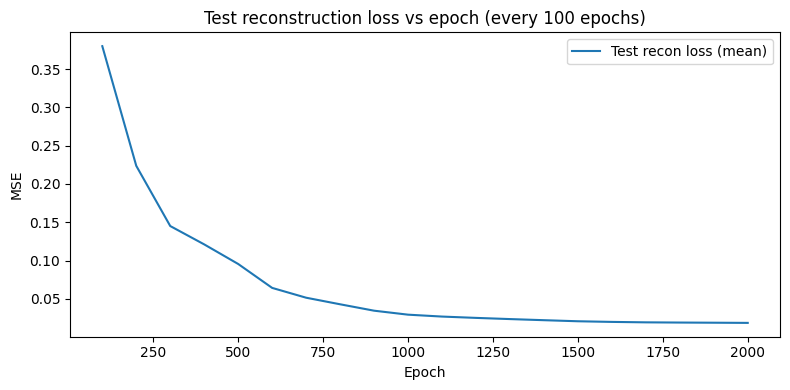

In [ ]:
# Test reconstruction loss every 100 epochs (mean ± SD)
import numpy as np
import matplotlib.pyplot as plt

log_every = 100
epochs = 2000   # use your cfg.epochs

xs = np.arange(log_every, epochs + 1, log_every)

# Mean and SD across replicates
test_loss_mean = np.array([
    np.mean(v) for v in history["per_epoch_test_recon_loss"]
])
test_loss_sd = np.array([
    np.std(v) for v in history["per_epoch_test_recon_loss"]
])

plt.figure(figsize=(8,4))
plt.plot(xs, test_loss_mean, label="Test recon loss (mean)")
plt.fill_between(
    xs,
    test_loss_mean - test_loss_sd,
    test_loss_mean + test_loss_sd,
    alpha=0.25
)
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Test reconstruction loss vs epoch (every 100 epochs)")
plt.legend()
plt.tight_layout()
plt.show()

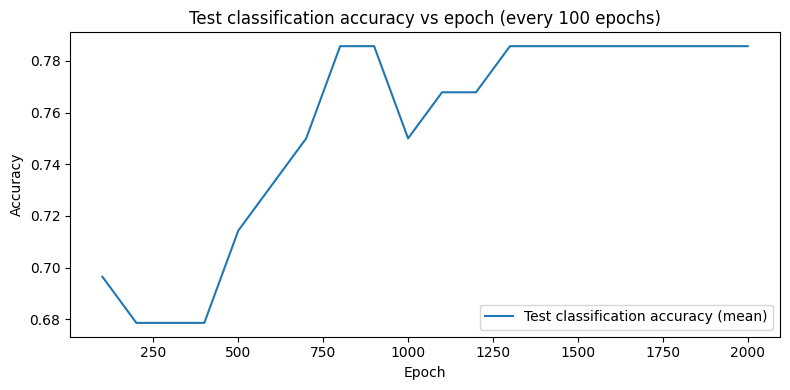

In [ ]:
# Test classification accuracy every 100 epochs (mean ± SD)
test_acc_mean = np.array([
    np.mean(v) for v in history["per_epoch_test_class_acc"]
])
test_acc_sd = np.array([
    np.std(v) for v in history["per_epoch_test_class_acc"]
])

plt.figure(figsize=(8,4))
plt.plot(xs, test_acc_mean, label="Test classification accuracy (mean)")
plt.fill_between(
    xs,
    test_acc_mean - test_acc_sd,
    test_acc_mean + test_acc_sd,
    alpha=0.25
)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test classification accuracy vs epoch (every 100 epochs)")
plt.legend()
plt.tight_layout()
plt.show()